# FAQ

## I just upgraded from skan v0.8 or 0.9 and my measurements are slightly different. What gives?

In skan v0.10, we added a new way to deal with junctions (see next question). This new method offered enough advantages that we decided to make it the default straight away. This should not affect the accuracy of the measurements provided by skan, but will result in small numerical differences of less than the pixel spacing of your dataset.

## What's `unique_junctions` or `junction_mode`?

When looking at the pixel-pixel graph of a skeleton, things get a little complicated at the junctions, where three or more branches meet. That's because junctions are defined as a pixel that has three or more neighbors, but topologically, these can occur in "clusters". This was explained in the [supplementary material of the original Skan paper](https://doi.org/10.7717/peerj.4312/supp-2). See the figure below for an example.

Prior to skan version 0.10, skan's approach to this problem was to collapse all such "bundles" to the centroid of the points.

This gives good results when making measurements on the branches and examining the topology of the network, but has the disadvantage that it breaks the link between skeleton graph nodes and the underlying pixels. For example, if we use the node coordinates to paint data on an image, we will not fill in all the pixel positions and we will end up with a disconnected skeleton.

In skan 0.10, we added a new strategy for dealing with the clusters: replace each cluster with its minimum spanning tree (MST). See [#133](https://github.com/jni/skan/issues/133).

All three approaches are summarized in the figure below:

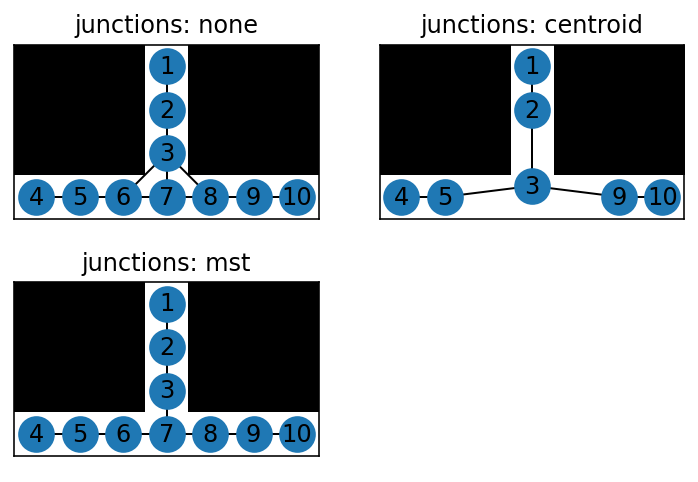

In [9]:
import matplotlib.pyplot as plt
from skan.csr import skeleton_to_csgraph
from skan import draw
from skan import _testdata

skel = _testdata.skeleton0

fig, axes = plt.subplots(2, 2)
axes[1, 1].set_axis_off()

for ax, mode in zip(axes.ravel(), ('none', 'centroid', 'mst')):
    graph, coordinates = skeleton_to_csgraph(skel, junction_mode=mode)
    draw.overlay_skeleton_networkx(
            graph, coordinates, image=skel, axis=ax
            )
    ax.set_title(f'junctions: {mode}')


The MST is now the default and will become the only supported method in skan 0.11 and later. If you absolutely need the earlier strategies, please [raise an issue](https://github.com/jni/skan/issues/new).

## Why are coordinates floats and not integers?

This is because in `junction_mode='centroid'`, coordinates of more than one pixel are collapsed into a single centroid value which is rarely an integer. In skan 0.11 and later, once MST is the only supported mode, coordinates will correspond 1-1 with pixel coordinates and be integer-valued.

## Why is coordinate (0, 0, 0) always in my coordinate list? / Why is the coordinate array larger than the number of nodes in the pixel graph?

This is done for implementation convenience. The coordinates contain *at least* the coordinates for every node in the pixel graph. However:
- The pixels in the skeleton are numbered 1..n. In order for each node ID to index directly into the coordinates array, the array must have a "dummy" coordinate at position 0. We considered using `np.nan` as a sentinel value to indicate that that position contained dummy data, but that would have made it more difficult to work with NumPy functions such as `np.min`/`np.max`, which would always return `np.nan` without special handling.
- Additionally, look closely at the figure in [What's unique_junctions or junction_mode?](#What's-unique_junctions-or-junction_mode?): during centroid-based junction consolidation, a bunch of pixel IDs are removed from the graph. However, we keep indexing using the original IDs, so the coordinates in the coordinate array now contain "unused" data.

See these GitHub issues for more details: [#93](https://github.com/jni/skan/issues/93) and [#108](https://github.com/jni/skan/issues/108).